<a href="https://colab.research.google.com/github/tohsin/Reinforcement_learning_projects/blob/main/DRL_grid_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/DRL/')

In [ ]:
import numpy as np
import torch 

import random
from matplotlib import pylab as plt
from Gridworld import Gridworld

In [ ]:
l1=64
l2=150
l3=100
l4=4

action_set={0:'u',
           1:'d',
           2:'l',
           3:'r'}

In [ ]:
#model definition passing in number of nerons

model=torch.nn.Sequential(
    torch.nn.Linear(l1,l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2,l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
#using mean squared error
loss_fn=torch.nn.MSELoss()
# my own learning rate ,find out why 1e-3 is commonly used in DEEP ish
le_r=1e-3
optimizer=torch.optim.Adam(model.parameters(),lr=le_r)

gamma=0.9
epsilon=1.0


In [ ]:
epochs=1000
#to store the loss so we can plot later
losses=[]

#training loop
for i in range (epochs):
    #for each epoch start a new  game episodic shii
    game=Gridworld(size=4,mode='static')
    #extract the game and add a bit of noise
    #we adding noise cause 0 doesnt play well with relu
    #so no value will be zero
    state_=game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    #convert numpy array to pytorch tensor then to variable
    state1=torch.from_numpy(state_).float()
    #to know if game is still on
    status=1
  
    while(status==1):
        string1="starting episode{}"
        print(string1.format(i))
        qval=model(state1)
        #what are u for
        qval_=qval.data.numpy()
        #select using e-greedy policy
        if(random.random() <epsilon):
            action_=np.random.randint(0,4)
        else:
            action_=np.argmax(qval_)
     
        action =action_set[action_]
        #taking the action after selecting epsilon greedy
        game.makeMove(action)
        
        state2_=game.board.render_np().reshape(1,64)+np.random.rand(1,64)/10.0
        state2=torch.from_numpy(state2_).float()
        reward=game.reward()
        
        #u dont want to back prob yet used to do evaluation
        #we only want to train based on state 1 not 2
        with torch.no_grad():
            newQ=model(state2.reshape(1,64))
        maxQ=torch.max(newQ)
        #since only time u dont get -1 is goal or pit
        #so no need to discount any future rewards ther isnt any
        #calc target q val
        if reward==-1:
            Y=reward +(gamma *maxQ)
        else:
            Y=reward
        #creates a copy of qval array and updates the one element
        #corresponding to the action take
        Y=torch.Tensor([Y]).detach()
        X=qval.squeeze()[action_]
        loss=loss_fn(X, Y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
        state1=state2
        if reward != -1:
            status=0
        string2="finishing episode{}"
        print(string2.format(i))
    if epsilon>0.1:
      epsilon -= (1/epochs)

print("Done")
        

starting episode0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
starting episode701
finishing episode701
starting episode702
finishing episode702
starting episode702
finishing episode702
starting episode702
finishing episode702
starting episode702
finishing episode702
starting episode702
finishing episode702
starting episode702
finishing episode702
starting episode702
finishing episode702
starting episode702
finishing episode702
starting episode702
finishing episode702
starting episode702
finishing episode702
starting episode702
finishing episode702
starting episode703
finishing episode703
starting episode703
finishing episode703
starting episode703
finishing episode703
starting episode703
finishing episode703
starting episode703
finishing episode703
starting episode703
finishing episode703
starting episode703
finishing episode703
starting episode703
finishing episode703
starting episode703
finishing episode703
starting episode703
finishing episode703
starting episode704
finishing episode704
starti

Text(0, 0.5, 'Loss')

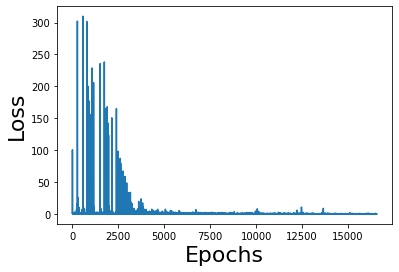

In [ ]:
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
def test_model(model,mode='static',display=True):
    i=0
    test_game=Gridworld(mode=mode)
    state_=test_game.board.render_np().reshape(1,64)+np.random.rand(1,64)/10.0
    state=torch.from_numpy(state_).float()
    if display:
        print("initial state:")
        print(test_game.display())
    status=1
    while(status==1):
            qval=model(state)
            #regression val to numpy
            qval_=qval.data.numpy()
            action_=np.argmax(qval_)
            action=action_set[action_]
            if display:
                print('Move #: %s; Taking action: %s' % (i, action))
            test_game.makeMove(action)
            state_ = test_game.board.render_np().reshape(1,64) +np.random.rand(1,64)/10.0
            state=torch.from_numpy(state_).float()
            if display:
                print(test_game.display())
            reward=test_game.reward()
            if reward !=-1:
                if reward>0:
                    status=2
                    if display:
                        print("game won:Reward:%s" %(reward,))
                else:
                    status=0
                    if display:
                        print("Game Lost Reward: %s"%(reward,))
            i+=1
            if(i>15):
                if display:
                    print("Game lost,too many moves")
                    break
    win=True if status==2 else False
    return win

In [ ]:
test_model(model)

initial state:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
game won:Reward:10


True

In [ ]:
test_model(model,'random')

initial state:
[['-' '+' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['-' '+' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['-' '+' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['-' '+' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['-' '+' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['-' '+' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: l
[['-' '+' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: l
[['-' '+' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 7; Taking action: l
[['-' '+' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 8; Taking action: l
[['-' '+' ' ' ' ']
 [' ' ' ' 'W' 'P']
 [

False

In [ ]:
#it cant generalise properly even when trained with radom
#so solution is too do batch traing called esperience replay
#even training with random doesnt work


In [ ]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)
print('done')
#A Set the total size of the experience replay memory
#B Set the minibatch size
#C Create the memory replay as a deque list
#D Maximum number of moves before game is over
#E Compute Q-values from input state in order to select action
#F Select action using epsilon-greedy strategy
#G Create experience of state, reward, action and next state as a tuple
#H Add experience to experience replay list
#I If replay list is at least as long as minibatch size, begin minibatch training
#J Randomly sample a subset of the replay list
#K Separate out the components of each experience into separate minibatch tensors
#L Re-compute Q-values for minibatch of states to get gradients
#M Compute Q-values for minibatch of next states but don't compute gradients
#N Compute the target Q-values we want the DQN to learn
#O If game is over, reset status and mov number

Streaming output truncated to the last 5000 lines.
4115 0.10617760568857193
4115 0.10299737751483917
4115 0.14182065427303314
4116 0.07008035480976105
4116 0.0824832022190094
4116 0.0986146330833435
4116 0.08045449107885361
4116 0.06752193719148636
4116 0.09212186187505722
4116 0.1095944419503212
4116 0.10883007198572159
4116 0.07643336057662964
4116 0.06990233063697815
4116 0.03893185779452324
4116 0.09724944084882736
4116 0.20293019711971283
4116 0.11845684051513672
4116 0.06719091534614563
4117 0.04305852949619293
4117 0.14704546332359314
4117 0.08119313418865204
4117 0.05247143283486366
4117 0.0762886106967926
4118 0.14417414367198944
4119 0.07746035605669022
4119 0.06471043825149536
4119 0.10997162014245987
4119 0.05990368872880936
4119 0.11244732141494751
4120 0.08957022428512573
4121 0.1382223516702652
4121 0.07079295068979263
4121 0.07795626670122147
4122 0.07090366631746292
4123 0.15786147117614746
4123 0.13193778693675995
4123 0.10927458852529526
4123 0.12616495788097382
4123

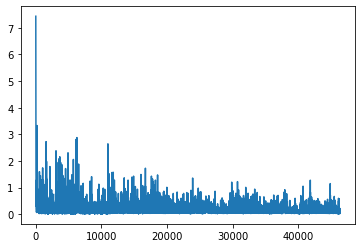

In [ ]:
plt.plot(losses)

In [ ]:
#testing performance with exp replay
max_games=1000
wins=0
for i in range(max_games):
  win=test_model(model,mode='random',display=False)
  print("played game number :{}".format(i+1))
  if win:
    wins+=1
win_perc=float(wins)/float(max_games)
print("Games played:{0}, # of wins:{1}".format(max_games,wins))
print("wins percentage: {}".format(win_perc))

played game number :1
played game number :2
played game number :3
played game number :4
played game number :5
played game number :6
played game number :7
played game number :8
played game number :9
played game number :10
played game number :11
